<a href="https://colab.research.google.com/github/ayten21/Speech-Recognition/blob/main/Speech_Recognition_with_WAV2VEC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import IPython
import matplotlib
import matplotlib.pyplot as plt
import requests
import torch
import torchaudio

In [5]:
matplotlib.rcParams['figure.figsize'] = [16.0, 4.8]
torch.random.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(torchaudio.__version__)
print(device)

1.11.0+cu113
0.11.0+cu113
cuda


In [6]:
speech_url = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
speech_file = '_assets/speech.wav'

if not os.path.exists(speech_file):
  os.makedirs('_assets', exist_ok = True)
  with open(speech_file, 'wb') as file:
    file.write(requests.get(speech_url).content)

Pipeline

There are two types of Wav2Vec2 pre-trained weights available in torchaudio. The ones fine-tuned for ASR task, and the ones not fine-tuned.

Wav2Vec2 (and HuBERT) models are trained in self-supervised manner. They are firstly trained with audio only for representation learning, then fine-tuned for a specific task with additional labels.

The pre-trained weights without fine-tuning can be fine-tuned for other downstream tasks as well

In [9]:
#The bundle object provides the interface to instantiate model and other information.
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print('Sample Rate:', bundle.sample_rate)
print('Labels:', bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [11]:
model = bundle.get_model().to(device)
print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [12]:
IPython.display.Audio(speech_file)

To load data, we use torchaudio.load().

If the sampling rate is different from what the pipeline expects, then we can use torchaudio.functional.resample() for resampling.
torchaudio.functional.resample() works on CUDA tensors as well.
When performing resampling multiple times on the same set of sample rates, using torchaudio.transforms.Resample() might improve the performace.

In [13]:
waveform, sample_rate = torchaudio.load(speech_file)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
  waveform = torchaudio.functional.resample(waveform, sample_rate, bundlle.sample_rate)

Extracting acoustic features

Wav2Vec2 models fine-tuned for ASR task can perform feature extraction and classification with one step. Below code is the example of how it could be done manually


In [14]:
with torch.inference_mode():
  features, _ = model.extract_features(waveform)

The returned features is a list of tensors. Each tensor is the output of a transformer layer.

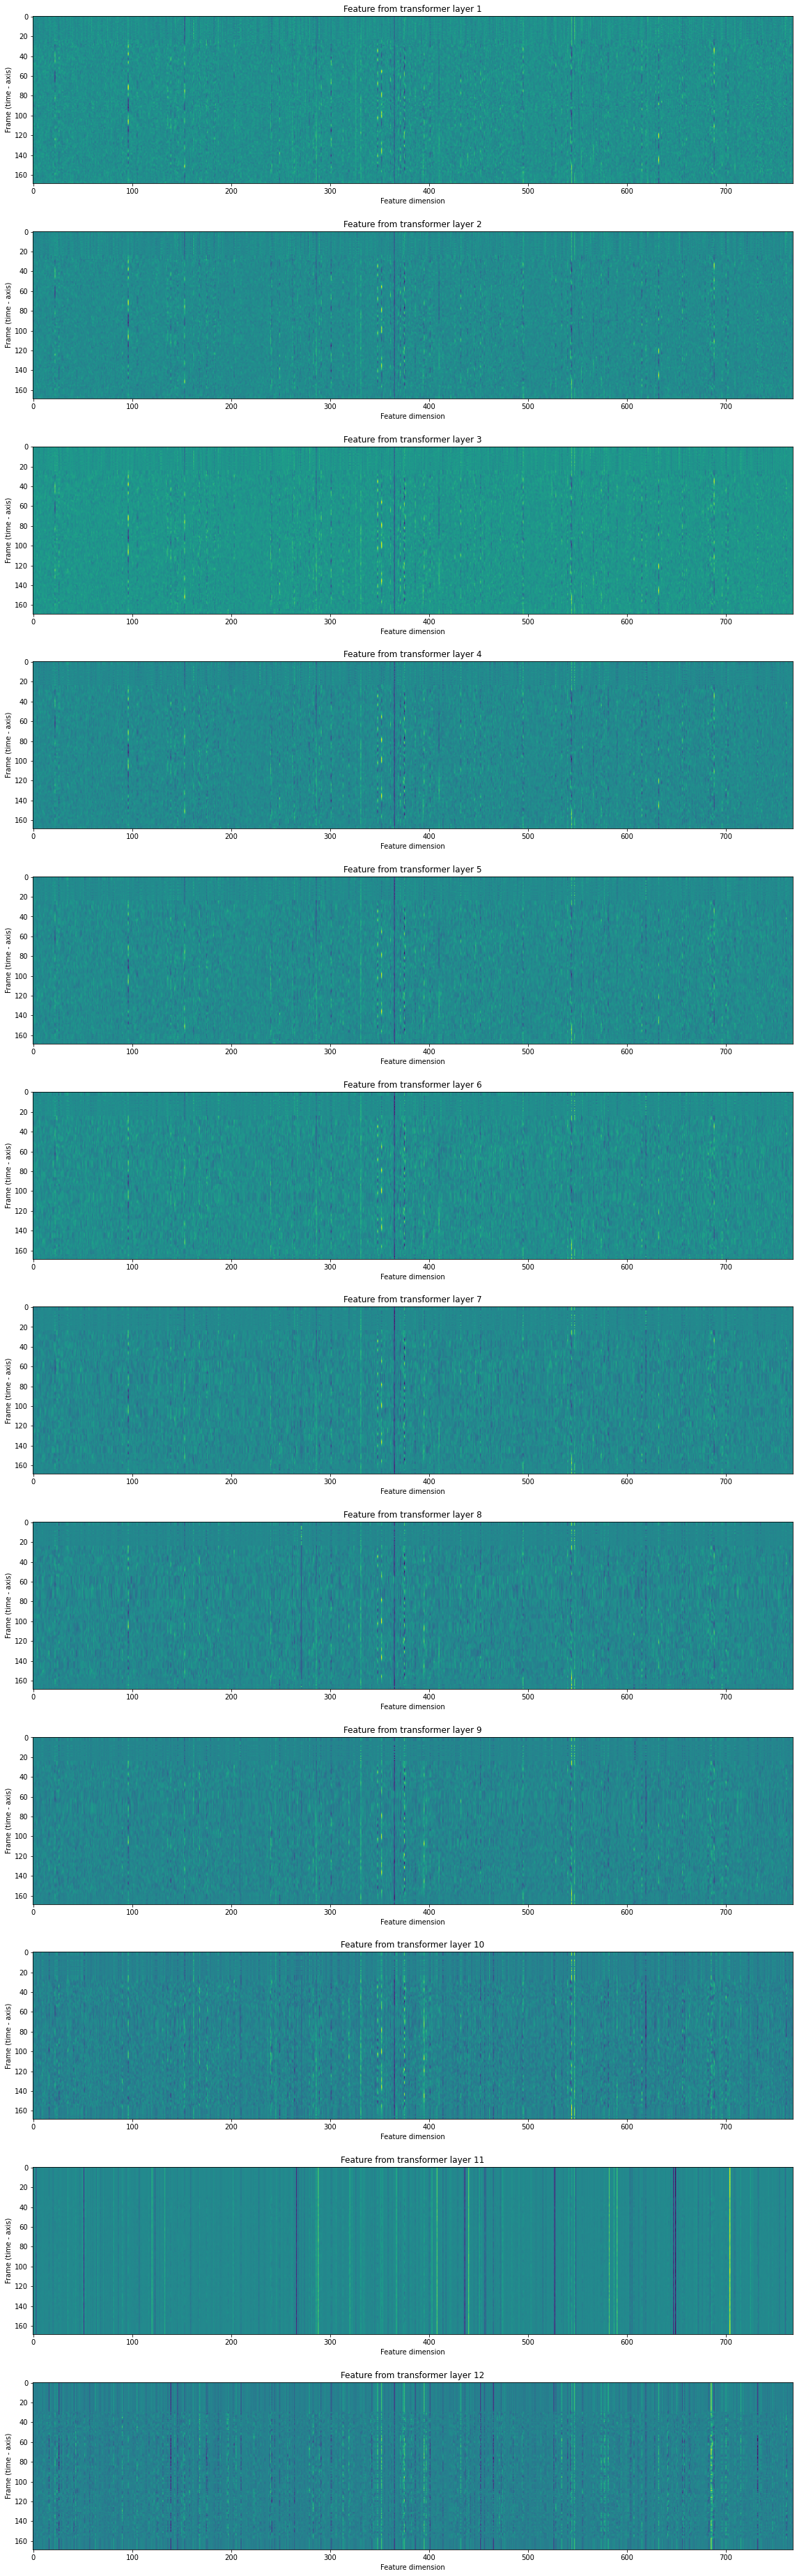

In [15]:
fig, ax = plt.subplots(len(features), 1, figsize = (16, 4.3 * len(features)))
for i, feats in enumerate(features):
  ax[i].imshow(feats[0].cpu())
  ax[i].set_title(f'Feature from transformer layer {i + 1}')
  ax[i].set_xlabel('Feature dimension')
  ax[i].set_ylabel('Frame (time - axis)')

plt.tight_layout()
plt.show()

Feature classification

The next step is to classify them into a set of categories.
Wav2Vec2 model provides method to perform the feature extraction and classification in one step.

In [16]:
with torch.inference_mode():
  emission, _ = model(waveform)

The output is in the form of logits. It is not in the form of probability.

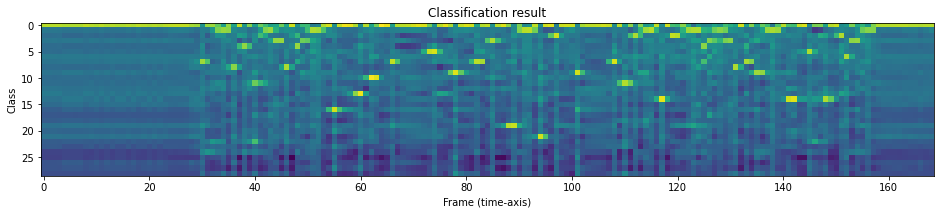

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [18]:
plt.imshow(emission[0].cpu().T)
plt.title('Classification result')
plt.xlabel('Frame (time-axis)')
plt.ylabel('Class')
plt.show()
print('Class labels:', bundle.get_labels())

Generating transcripts

The process to generate transcripts is often called “decoding”.
To accurately generate transcripts, the decoding process has to postpone the final decision until it sees enough context.
There are many decoding techniques proposed, and they require external resources, such as word dictionary and language models.
This is the type of decoding which does not depend on such external components, and simply pick up the best hypothesis at each time step. Therefore, the context information are not used, and only one transcript can be generated.


In [19]:
class GreedyCTCDecoder(torch.nn.Module):
  def __init__(self, labels, blank = 0):
    super().__init__()
    self.labels = labels
    self.blank = blank

  def forward(self, emission = torch.Tensor) -> str:
    indices = torch.argmax(emission, dim = -1)
    indices = torch.unique_consecutive(indices, dim = -1)
    indices = [i for i in indices if i != self.blank]
    return ''.join([self.labels[i] for i in indices])

In [20]:
decoder = GreedyCTCDecoder(labels = bundle.get_labels())
transcript = decoder(emission[0])

In [21]:
print(transcript)
IPython.display.Audio(speech_file)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|
